In [2]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import pickle as pkl
sys.path.append(os.path.join(os.getcwd(), "Model_utils"))
sys.path.append(os.path.join(os.getcwd()))
import other_billeh_utils


2025-03-09 13:57:46.099088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## V1-LM model connectivity

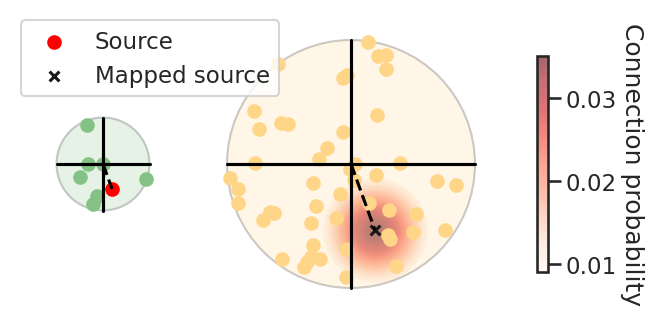

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

# Function to generate random points inside a circle
def generate_random_points_inside_circle(center, radius, num_points):
    angles = 2 * np.pi * np.random.rand(num_points)
    radii = radius * np.sqrt(np.random.rand(num_points))
    x_points = center[0] + radii * np.cos(angles)
    y_points = center[1] + radii * np.sin(angles)
    return x_points, y_points

# Circle 1 parameters
circle1_center = (100, 500)
circle1_radius = 400

# Circle 2 parameters
circle2_center = (-700, 500)
circle2_radius = 150

radius_ratio = circle2_radius / circle1_radius

# Number of random points to generate inside each circle
num_points_inside_circle1 = 50
num_points_inside_circle2 = int(num_points_inside_circle1 * radius_ratio**2)

# Generate random points inside Circle 1
x_points_circle1, y_points_circle1 = generate_random_points_inside_circle(circle1_center, circle1_radius, num_points_inside_circle1)

# Generate random points inside Circle 2
x_points_circle2, y_points_circle2 = generate_random_points_inside_circle(circle2_center, circle2_radius, num_points_inside_circle2)

# Plotting
plt.figure(figsize=(8, 8))
circle1 = plt.Circle(circle1_center, circle1_radius, edgecolor='black', facecolor='#ffd588', alpha=0.2, fill=True)
circle2 = plt.Circle(circle2_center, circle2_radius, edgecolor='black', facecolor='#84c184', alpha=0.2, fill=True)


plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

plt.scatter(x_points_circle1, y_points_circle1, color='#ffd588')
plt.scatter(x_points_circle2, y_points_circle2, color='#84c184')

# give a radom x and y within circle 1
x, y = generate_random_points_inside_circle(circle1_center, circle1_radius*0.7, 1)
r, phi = cart2pol(x-circle1_center[0], y-circle1_center[1])
projected_x, projected_z = pol2cart(r*radius_ratio, phi)
plt.scatter(projected_x+circle2_center[0], projected_z+circle2_center[1], color='red', label='Source')
plt.scatter(x, y, color='k', marker='x', s=50, label='Mapped source')
x = x[0]
y = y[0]
projected_x = projected_x[0]
projected_z = projected_z[0]
r = r[0]
phi = phi[0]

# draw axis in circle1_center and circle2_center
plt.plot([circle1_center[0]-circle1_radius, circle1_center[0]+circle1_radius], [circle1_center[1], circle1_center[1]], color='black')
plt.plot([circle1_center[0], circle1_center[0]], [circle1_center[1]-circle1_radius, circle1_center[1]+circle1_radius], color='black')
plt.plot([circle2_center[0]-circle2_radius, circle2_center[0]+circle2_radius], [circle2_center[1], circle2_center[1]], color='black')
plt.plot([circle2_center[0], circle2_center[0]], [circle2_center[1]-circle2_radius, circle2_center[1]+circle2_radius], color='black')

# include a dashed line from the circle center to the red random point
plt.plot([circle1_center[0], x], [circle1_center[1], y], color='black', linestyle='dashed')
plt.plot([circle2_center[0], projected_x+circle2_center[0]], [circle2_center[1], projected_z+circle2_center[1]], color='black', linestyle='dashed')

r = np.sqrt((x-circle1_center[0])**2 + (y-circle1_center[1])**2)
circle3_center = (x, y)
circle3_radius = circle1_radius - r

# Create a grid of points inside Circle 2
x_grid, y_grid = np.meshgrid(np.linspace(x - circle3_radius, x + circle3_radius, 500),
                             np.linspace(y - circle3_radius, y + circle3_radius, 500))

# Calculate radial distances from the center of Circle 2
r_grid = np.sqrt((x_grid - x)**2 + (y_grid - y)**2)

# apply a circular mask to the r_grid
r_grid = np.ma.masked_where(r_grid > circle3_radius, r_grid)

# Define the Gaussian color heatmap
sigma = 148
color_heatmap = 0.035 * np.exp(-(r_grid**2) / (sigma**2))

# Create the Gaussian color heatmap inside Circle 2
plt.imshow(color_heatmap, extent=[circle3_center[0] - circle3_radius, circle3_center[0] + circle3_radius,
                                  circle3_center[1] - circle3_radius, circle3_center[1] + circle3_radius],
           cmap='Reds', origin='lower', alpha=0.6, aspect='auto')

# Include colorbar
cbar = plt.colorbar(shrink=0.35, pad=-0.05)
cbar.set_label('Connection probability', rotation=270, labelpad=20)


plt.xlim(-1000, 800)
plt.ylim(0, 1000)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
# plt.title('Random Points in Circles')
plt.legend(loc='upper left')
plt.grid(False)
plt.axis('off')
# set equal aspect
plt.gca().set_aspect('equal', adjustable='box')

# plt.savefig('LM_V1_connectivity_scheme.png', dpi=1000, transparent = True)

plt.show()

## V1 column MNIST

In [4]:
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)
network = networks['v1']

data_dir = 'GLIF_network'

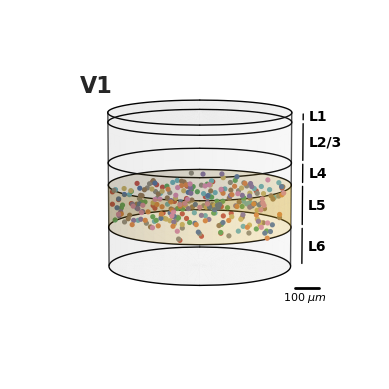

In [27]:
sns.set(style="ticks", context="talk")
# plt.style.use('classic')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_circ = np.linspace(-400, 400, 100)
z_circ = np.sqrt(400**2 - x_circ**2)
x_vert = np.zeros((100))
z_vert = 450*np.ones((100))
R = np.linspace(0, 400, 100)
u = np.linspace(0,  2*np.pi, 100)
x = np.outer(R, np.cos(u))
z = np.outer(R, np.sin(u))
upper_limit = -50
layer_limits = [-100, -310, -425, -645, -850]
layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']

# Draw cylinder outline
ax.plot(x_circ, z_circ, -50, color='black', linewidth=1, alpha=1)
ax.plot(x_circ, -z_circ, -50, color='black', linewidth=1, alpha=1)

# Add light gray shading for the entire cylinder
# Side walls of the cylinder
theta = np.linspace(0, 2*np.pi, 50)
height = np.linspace(-50, -850, 10)
theta_grid, height_grid = np.meshgrid(theta, height)
x_grid = 400 * np.cos(theta_grid)
z_grid = 400 * np.sin(theta_grid)
ax.plot_surface(x_grid, z_grid, height_grid, alpha=0.05, color='lightgray', linewidth=0)

# Top surface
ax.plot_surface(x, z, upper_limit*np.ones(x.shape), alpha=0.05, color='lightgray', linewidth=0, shade=True)

# Bottom surface
ax.plot_surface(x, z, -850*np.ones(x.shape), alpha=0.05, color='lightgray', linewidth=0, shade=True)

for layer, lower_limit in zip(layers, layer_limits):
    ax.plot(x_circ, z_circ, lower_limit, color='black', linewidth=1, alpha=1)
    ax.plot(x_circ, -z_circ, lower_limit, color='black', linewidth=1, alpha=1)

    # Lateral layers legend with bold text
    ax.plot(np.zeros((100)), 450 * np.ones((100)), np.linspace(lower_limit + 10, upper_limit - 10, 100), 
            color='black', linewidth=1, alpha=1)
    ax.text(0, 475, np.mean([lower_limit, upper_limit]), layer, 
            color='black', fontsize=10, verticalalignment='center', fontweight='bold')
    upper_limit = lower_limit

z_scale = np.linspace(400, 500, 100)
x_scale = 450*np.ones(100)
y_scale = -850*np.ones(100)
ax.plot(x_scale, z_scale, y_scale, color='black', linewidth=2, alpha=1)    
ax.text(670, 430, -850, r'100 $\mu m$', color='black', fontsize=8, horizontalalignment='center')

# Vertical bars from the cylinder
y = np.linspace(-50, -850, 100)
x = np.zeros(100)
z = 400*np.ones(100)
ax.plot(x, z, y, color='black', linewidth=1, alpha=0.7)    
ax.plot(x, -z, y, color='black', linewidth=1, alpha=0.7)    

us = np.linspace(np.pi, 3 * np.pi, 1000)
zs = np.linspace(-425, -645, 1000)
us, zs = np.meshgrid(us, zs)
xs = 400 * np.cos(us)
ys = 400 * np.sin(us)
highlight_color = '#ffbf00'  # Golden yellow for Layer 5 highlight
ax.plot_surface(xs, ys, zs, alpha=0.2, color=highlight_color, linewidth=0, shade=True)

for i in range(10):
    neurons_ids = networks['v1'][f'readout_neuron_ids_{i}']
    x_ids = networks['v1']['x'][neurons_ids]
    y_ids = networks['v1']['y'][neurons_ids]
    z_ids = networks['v1']['z'][neurons_ids]
    ax.scatter(x_ids, z_ids, y_ids, 'o', alpha=1, s=5, label=f'readout_population_{i}')

#set lims to the axis
plt.xlim(-500, 500)
plt.ylim(-500, 500)
# Add column label
ax.text(0, -450, 50, 'V1', fontsize=16, ha='center', fontweight='bold')

plt.axis('off')
ax.view_init(elev=10, azim=0)

# plt.tight_layout()
plt.savefig(os.path.join("model_L5_highlighting.png"), dpi=300, transparent=True)
plt.show()

Text(0.5, 1.0, 'LGN-V1-LM Connectivity with Readout Populations')

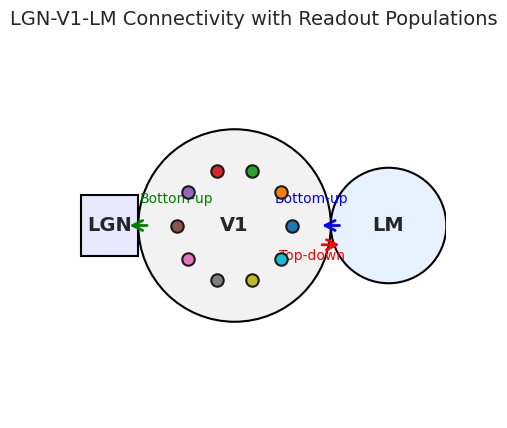

In [34]:
# For Panel B (connectivity visualization)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Increased figure width to accommodate LGN

# Create a simplified top-down view of LGN-V1-LM connectivity
# LGN rectangle - wider than tall
lgn_rect = plt.Rectangle((0.05, 0.42), 0.15, 0.16, edgecolor='black', facecolor='#e8e8ff', alpha=1, 
                        fill=True, zorder=1)

# V1 circle - moved further right to increase spacing from LGN
v1_circle = plt.Circle((0.45, 0.5), 0.25, edgecolor='black', facecolor='#f2f2f2', alpha=1, fill=True)

# LM circle - moved further right to increase spacing from V1
lm_circle = plt.Circle((0.85, 0.5), 0.15, edgecolor='black', facecolor='#e6f2ff', alpha=1, fill=True)

# Add patches
ax.add_patch(lgn_rect)
ax.add_patch(v1_circle)
ax.add_patch(lm_circle)

# Label the regions
ax.text(0.125, 0.5, 'LGN', fontsize=14, ha='center', va='center', fontweight='bold')
ax.text(0.45, 0.5, 'V1', fontsize=14, ha='center', va='center', fontweight='bold')
ax.text(0.85, 0.5, 'LM', fontsize=14, ha='center', va='center', fontweight='bold')

# Show connectivity with arrows - adjusted for new positions
# LGN to V1 (bottom-up)
ax.annotate('', xy=(0.45-0.25-0.03, 0.5), xytext=(0.2+0.03, 0.5), 
            arrowprops=dict(arrowstyle='->', lw=2, color='green'))

# V1 to LM (bottom-up/feedforward)
ax.annotate('', xy=(0.85-0.15-0.03, 0.5), xytext=(0.45+0.25+0.03, 0.5), 
            arrowprops=dict(arrowstyle='->', lw=2, color='blue'))

# LM to V1 (top-down/feedback)
ax.annotate('', xy=(0.45+0.25+0.03, 0.45), xytext=(0.85-0.15-0.03, 0.45), 
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

# Add connectivity labels - adjusted for new positions
ax.text(0.3, 0.56, 'Bottom-up', fontsize=10, ha='center', color='green')
ax.text(0.65, 0.56, 'Bottom-up', fontsize=10, ha='center', color='blue')
ax.text(0.65, 0.41, 'Top-down', fontsize=10, ha='center', color='red')

# Highlight L5 readout populations in V1 - adjusted for new position
for i in range(10):
    theta = 2*np.pi*i/10
    r = 0.15  # Inner radius for population markers
    ax.scatter(0.45 + r*np.cos(theta), 0.5 + r*np.sin(theta), 
               s=80, color=readout_colors[i], edgecolor='k', zorder=10)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('LGN-V1-LM Connectivity with Readout Populations', fontsize=14)

Text(0.5, 1.0, 'MNIST Digit Examples')

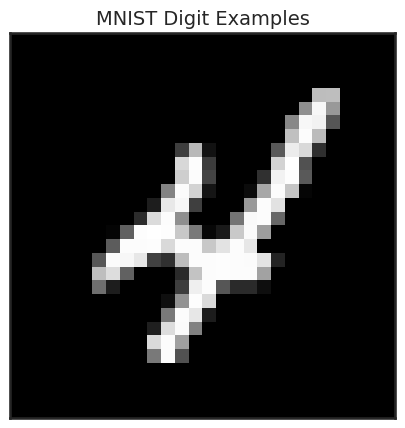

In [ ]:
import tensorflow as tf

fig, ax = plt.subplots(1, 1, figsize=(8, 5))  

# Load the MNIST dataset and preprocess the images
all_ds = tf.keras.datasets.mnist.load_data()
(images, labels), _ = all_ds
if len(images.shape) > 3:
    mnist_examples = tf.image.rgb_to_grayscale(images) / 255
else:
    mnist_examples = images[..., None] / 255

# Display sample MNIST digits
# Assuming you have example digits for each class
grid_size = (2, 5)
for i in range(10):
    row, col = i // grid_size[1], i % grid_size[1]
    ax.imshow(mnist_examples[i], cmap='gray', 
              extent=[col, col+1, grid_size[0]-row, grid_size[0]-row-1])

ax.set_xlim(0, grid_size[1])
ax.set_ylim(0, grid_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('MNIST Digit Examples', fontsize=14)

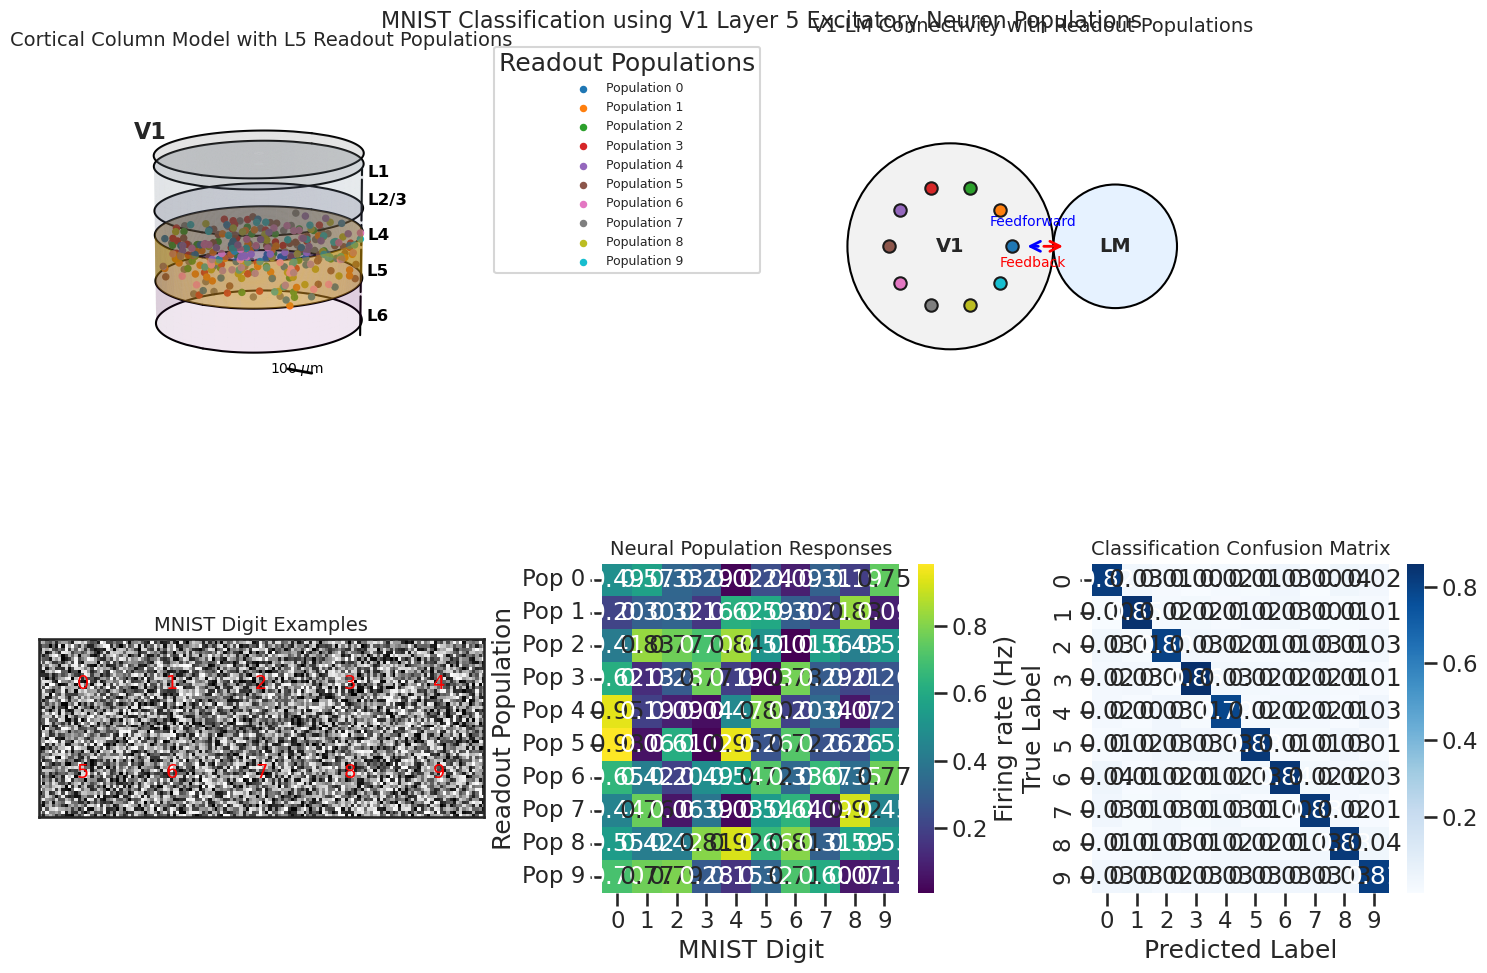

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Set up the multi-panel figure
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.8], width_ratios=[1.2, 1, 1])
# Panel A: Enhanced 3D cortical model visualization
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
# [Enhanced version of your existing 3D visualization]
# Panel B: Connectivity between V1 and LM
ax2 = fig.add_subplot(gs[0, 1:])
# [New visualization showing connectivity]
# Panel C: Example MNIST digits and neural responses
ax3 = fig.add_subplot(gs[1, 0])
# [MNIST examples visualization]
# Panel D: Neural activity patterns
ax4 = fig.add_subplot(gs[1, 1])
# [Visualization of neural population responses]
# Panel E: Classification performance
ax5 = fig.add_subplot(gs[1, 2])
# [Classification performance visualization]

# For Panel A (enhancing your existing visualization)
ax = ax1  # Reuse your existing code but with improved visuals

# Use a better color scheme for layers
layer_colors = ['#e6e6e6', '#b3cde3', '#8c96c6', '#8856a7', '#810f7c']
highlight_color = '#ffbf00'  # Golden yellow for Layer 5 highlight
# Make readout populations more distinct
readout_colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Use distinct colors for each population
# Your existing code with modifications:
sns.set(style="ticks", context="talk")
# Enhanced from your existing code
x_circ = np.linspace(-400, 400, 100)
z_circ = np.sqrt(400**2 - x_circ**2)
upper_limit = -50
layer_limits = [-100, -310, -425, -645, -850]
layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']

# Draw the layers with better colors and transparency
ax.plot(x_circ, z_circ, -50, color='black', linewidth=1.5, alpha=1)
ax.plot(x_circ, -z_circ, -50, color='black', linewidth=1.5, alpha=1)

# Add the cylinder layers with different colors for each layer
for i, (layer, lower_limit) in enumerate(zip(layers, layer_limits)):
    ax.plot(x_circ, z_circ, lower_limit, color='black', linewidth=1.5, alpha=1)
    ax.plot(x_circ, -z_circ, lower_limit, color='black', linewidth=1.5, alpha=1)
    
    # Fill layer with appropriate color
    R = np.linspace(0, 400, 20)
    u = np.linspace(0, 2*np.pi, 30)
    x = np.outer(R, np.cos(u))
    z = np.outer(R, np.sin(u))
    y_top = upper_limit * np.ones(x.shape)
    y_bottom = lower_limit * np.ones(x.shape)
    
    # Plot top and bottom surfaces with appropriate coloring
    ax.plot_surface(x, z, y_top, alpha=0.2, color=layer_colors[i], linewidth=0, shade=True)
    
    # Side walls of each layer cylinder
    if i > 0:  # Only draw vertical walls for layers below L1
        theta = np.linspace(0, 2*np.pi, 50)
        height = np.linspace(upper_limit, lower_limit, 10)
        theta_grid, height_grid = np.meshgrid(theta, height)
        x_grid = 400 * np.cos(theta_grid)
        z_grid = 400 * np.sin(theta_grid)
        ax.plot_surface(x_grid, z_grid, height_grid, alpha=0.1, color=layer_colors[i], linewidth=0)
    
    # Lateral layers legend with improved visibility
    ax.plot(np.zeros((100)), 450 * np.ones((100)), np.linspace(lower_limit + 10, upper_limit - 10, 100), 
            color='black', linewidth=1.5, alpha=1)
    ax.text(0, 475, np.mean([lower_limit, upper_limit]), layer, 
            color='black', fontsize=12, verticalalignment='center', fontweight='bold')
    
    upper_limit = lower_limit

# Highlight L5 more prominently (where your readout populations are)
us = np.linspace(np.pi, 3 * np.pi, 1000)
zs = np.linspace(-425, -645, 1000)
us, zs = np.meshgrid(us, zs)
xs = 400 * np.cos(us)
ys = 400 * np.sin(us)
ax.plot_surface(xs, ys, zs, alpha=0.4, color=highlight_color, linewidth=0, shade=True)

# Plot readout populations with distinct colors and larger markers
for i in range(10):
    neurons_ids = networks['v1'][f'readout_neuron_ids_{i}']
    x_ids = networks['v1']['x'][neurons_ids]
    y_ids = networks['v1']['y'][neurons_ids]
    z_ids = networks['v1']['z'][neurons_ids]
    ax.scatter(x_ids, z_ids, y_ids, 'o', alpha=1, s=15, color=readout_colors[i], 
               label=f'Population {i}')

# Add column label
ax.text(0, -500, -50, 'V1', fontsize=16, ha='center', fontweight='bold')

# Add a scale indicator
z_scale = np.linspace(400, 500, 100)
x_scale = 450*np.ones(100)
y_scale = -850*np.ones(100)
ax.plot(x_scale, z_scale, y_scale, color='black', linewidth=2, alpha=1)    
ax.text(470, 450, -850, r'100 $\mu$m', color='black', fontsize=10, horizontalalignment='center')

# Add a legend for readout populations with better positioning
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, title='Readout Populations')

# Turn off all grid and axes elements
ax.set_axis_off()  # This completely removes the axes
ax.grid(False)  # This removes the grid

ax.view_init(elev=15, azim=30)  # Better viewing angle
ax.set_title('Cortical Column Model with L5 Readout Populations', fontsize=14, y=1.05)

# For Panel B (connectivity visualization)
ax = ax2

# Create a simplified top-down view of V1-LM connectivity
# V1 circle
v1_circle = plt.Circle((0.3, 0.5), 0.25, edgecolor='black', facecolor='#f2f2f2', alpha=1, fill=True)
# LM circle
lm_circle = plt.Circle((0.7, 0.5), 0.15, edgecolor='black', facecolor='#e6f2ff', alpha=1, fill=True)

ax.add_patch(v1_circle)
ax.add_patch(lm_circle)

# Label the regions
ax.text(0.3, 0.5, 'V1', fontsize=14, ha='center', va='center', fontweight='bold')
ax.text(0.7, 0.5, 'LM', fontsize=14, ha='center', va='center', fontweight='bold')

# Show connectivity with arrows
ax.annotate('', xy=(0.48, 0.5), xytext=(0.7-0.15-0.03, 0.5), 
            arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax.annotate('', xy=(0.3+0.25+0.03, 0.5), xytext=(0.52, 0.5), 
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

# Add connectivity labels
ax.text(0.5, 0.55, 'Feedforward', fontsize=10, ha='center', color='blue')
ax.text(0.5, 0.45, 'Feedback', fontsize=10, ha='center', color='red')

# Highlight L5 readout populations in V1
for i in range(10):
    theta = 2*np.pi*i/10
    r = 0.15  # Inner radius for population markers
    ax.scatter(0.3 + r*np.cos(theta), 0.5 + r*np.sin(theta), 
               s=80, color=readout_colors[i], edgecolor='k', zorder=10)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('V1-LM Connectivity with Readout Populations', fontsize=14)

# For Panel C (MNIST examples)
ax = ax3

# Display sample MNIST digits
# Assuming you have example digits for each class
mnist_examples = np.random.rand(10, 28, 28)  # Replace with actual MNIST examples
grid_size = (2, 5)
for i in range(10):
    row, col = i // grid_size[1], i % grid_size[1]
    ax.imshow(mnist_examples[i], cmap='gray', 
              extent=[col, col+1, grid_size[0]-row, grid_size[0]-row-1])
    ax.text(col+0.5, grid_size[0]-row-0.5, str(i), 
            ha='center', va='center', fontsize=14, color='red')

ax.set_xlim(0, grid_size[1])
ax.set_ylim(0, grid_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('MNIST Digit Examples', fontsize=14)

# For Panel D (neural population responses)
ax = ax4

# Create a heatmap showing firing rates for each population per digit
# Replace with your actual data
population_activity = np.random.rand(10, 10)  # 10 populations × 10 digits

# Create heatmap
sns.heatmap(population_activity, cmap='viridis', annot=True, fmt='.2f', 
            xticklabels=range(10), yticklabels=[f'Pop {i}' for i in range(10)],
            ax=ax, cbar_kws={'label': 'Firing rate (Hz)'})

ax.set_xlabel('MNIST Digit')
ax.set_ylabel('Readout Population')
ax.set_title('Neural Population Responses', fontsize=14)

# For Panel E (classification performance)
ax = ax5

# Create example confusion matrix (replace with your actual data)
confusion = np.eye(10) * 0.8 + np.random.rand(10, 10) * 0.2
np.fill_diagonal(confusion, confusion.diagonal() * 5)  # Emphasize diagonal
confusion = confusion / confusion.sum(axis=0, keepdims=True)  # Normalize

# Plot confusion matrix
sns.heatmap(confusion, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10), ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Confusion Matrix', fontsize=14)

# Overall figure adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('MNIST Classification using V1 Layer 5 Excitatory Neuron Populations', 
             fontsize=16, y=0.98)


# Save the figure in high resolution
plt.savefig('cortical_model_mnist_classification.png', dpi=300, bbox_inches='tight')
plt.show()